In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv("datasets/Chamau_2001-2024.csv")

# filter out rows without a response variable
# df = df[df["FN2O_L3.1_L3.3_CUT_50_QCF0"].notna()]

cols = [
    # Target
    "FN2O_L3.1_L3.3_CUT_50_QCF0",

    # Timestamp
    "TIMESTAMP_MIDDLE",
    
    # Predictors
    "NEE_L3.1_L3.3_CUT_50_QCF_gfRF",
    "GPP_NT_CUT_50_gfRF",
    "RECO_NT_CUT_50_gfRF",
    "SW_IN_T1_2_1",
    "TA_T1_2_1",
    "PREC_RAIN_TOT_GF1_0.5_1",
    "VPD_T1_2_1",
    "SWC_GF1_0.05_1",
    "SWC_GF1_0.15_1",
    "TS_GF1_0.04_1",
    "TS_GF1_0.15_1",
    "MGMT_MOWING",
    "MGMT_FERT_ORG",
    "MGMT_FERT_MIN",
    "MGMT_GRAZING",
    "MGMT_SOILCULTIVATION"
]

chamau = df[cols]

rename_map = {
    "FN2O_L3.1_L3.3_CUT_50_QCF0": "N2O_Flux",
    "TIMESTAMP_MIDDLE": "Timestamp",
    "NEE_L3.1_L3.3_CUT_50_QCF_gfRF": "NEE", # Net CO₂ exchange between field and atmosphere (positive = CO₂ released, negative = CO₂ uptake)
    "GPP_NT_CUT_50_gfRF": "GPP",            # Total CO₂ fixed by photosynthesis (proxy for plant growth)
    "RECO_NT_CUT_50_gfRF": "RECO",          # CO₂ emitted via respiration of plants and soil organisms
    "SW_IN_T1_2_1": "SolarRadiation",
    "TA_T1_2_1": "AirTemp",
    "PREC_RAIN_TOT_GF1_0.5_1": "Precipitation",
    "VPD_T1_2_1": "VPD",                    # Vapor pressure deficit
    "SWC_GF1_0.05_1": "SoilWater_5cm",
    "SWC_GF1_0.15_1": "SoilWater_15cm",
    "TS_GF1_0.04_1": "SoilTemp_4cm",
    "TS_GF1_0.15_1": "SoilTemp_15cm",
    "MGMT_MOWING": "Mowing",
    "MGMT_FERT_ORG": "FertilizerOrganic",
    "MGMT_FERT_MIN": "FertilizerMineral",
    "MGMT_GRAZING": "Grazing",
    "MGMT_SOILCULTIVATION": "SoilCultivation",
}

chamau = chamau.rename(columns=rename_map)
chamau["Timestamp"] = pd.to_datetime(chamau["Timestamp"])
chamau = chamau.sort_values("Timestamp")


# extract year and hour
chamau["year"] = chamau["Timestamp"].dt.year
chamau["hour"] = chamau["Timestamp"].dt.hour
chamau["month"] = chamau["Timestamp"].dt.month

In [3]:
chamau.head(5)

N2O_Flux           Timestamp       NEE       GPP      RECO  \
123525  1.015646 2012-01-18 10:45:00  0.384162  2.155036  2.539198   
123527  1.980485 2012-01-18 11:45:00 -1.633831  4.347880  2.714049   
123528  2.118028 2012-01-18 12:15:00 -3.494060  6.304054  2.809994   
123529  2.612216 2012-01-18 12:45:00 -2.778956  5.651104  2.872148   
123530  2.577871 2012-01-18 13:15:00 -1.157215  4.088506  2.931292   

        SolarRadiation  AirTemp  Precipitation       VPD  SoilWater_5cm  \
123525      292.290008 -3.33910            0.0  0.051046      57.517658   
123527      343.850006 -1.23810            0.0  0.071209      57.513504   
123528      356.149994 -0.05813            0.0  0.099947      57.418747   
123529      386.369995  0.72053            0.0  0.142029      57.380260   
123530      375.429993  1.47070            0.0  0.175308      57.377155   

        SoilWater_15cm  SoilTemp_4cm  SoilTemp_15cm  Mowing  \
123525       46.201393       0.09065         1.6995     0.0   
123527       46.197323       0.10388         1.6570     0.0   
123528       46.200577       0.08519         1.6725     0.0   
123529       46.206280       0.08846         1.6708     0.0   
123530       46.203831       0.09295         1.6661     0.0   

        FertilizerOrganic  FertilizerMineral  Grazing  SoilCultivation  year  \
123525                1.0                0.0      0.0              0.0  2012   
123527                1.0                0.0      0.0              0.0  2012   
123528                1.0                0.0      0.0              0.0  2012   
123529                1.0                0.0      0.0              0.0  2012   
123530                1.0                0.0      0.0              0.0  2012   

        hour  month  
123525    10      1  
123527    11      1  
123528    12      1  
123529    12      1  
123530    13      1

In [7]:
# --- 1️⃣ Create a copy for lag features ---
chamau_lag = chamau.copy()
chamau_lag["Timestamp"] = pd.to_datetime(chamau_lag["Timestamp"])
chamau_lag = chamau_lag.sort_values("Timestamp").set_index("Timestamp")

# --- 2️⃣ Continuous predictors (lags) ---
meteo_predictors = [
    "NEE", "GPP", "RECO",
    "SolarRadiation", "AirTemp", "Precipitation", "VPD",
    "SoilWater_5cm", "SoilWater_15cm",
    "SoilTemp_4cm", "SoilTemp_15cm"
]

lags_days = [1, 3, 5, 7]  # days back

for var in meteo_predictors:
    for lag in lags_days:
        chamau_lag[f"{var}_lag{lag}d"] = chamau_lag[var].shift(freq=pd.Timedelta(days=lag))

# --- 3️⃣ Management events (days since last event) ---
event_cols = [
    "Mowing", "FertilizerOrganic", "FertilizerMineral",
    "Grazing", "SoilCultivation"
]

def days_since_event(series, max_days=30):
    """Return number of days since last management event (cap at max_days)."""
    days = np.full(len(series), np.nan)
    last_event_idx = None
    for i, val in enumerate(series):
        if val == 1:
            last_event_idx = i
            days[i] = 0
        elif last_event_idx is not None:
            delta = (series.index[i] - series.index[last_event_idx]).total_seconds() / 86400
            days[i] = min(delta, max_days)
        else:
            days[i] = 30 #set to max
    return days

for col in event_cols:
    chamau_lag[f"DaysSince_{col}"] = days_since_event(chamau_lag[col], max_days=30)

# --- 4️⃣ Restore Timestamp as column if desired ---
chamau_lag = chamau_lag.reset_index()
chamau_lag = chamau_lag[chamau_lag["N2O_Flux"].notna()]

# --- 5️⃣ Quick preview ---
cols_to_show = [c for c in chamau_lag.columns if "lag" in c or "DaysSince" in c]
print(chamau_lag[["Timestamp", "N2O_Flux"] + cols_to_show].head(10))

                 Timestamp  N2O_Flux  NEE_lag1d  NEE_lag3d  NEE_lag5d  \
123525 2012-01-18 10:45:00  1.015646  -0.543474  -3.900783  -1.565954   
123527 2012-01-18 11:45:00  1.980485   5.553640  -5.366240  -5.682990   
123528 2012-01-18 12:15:00  2.118028  -4.049932  -3.917232  -2.141884   
123529 2012-01-18 12:45:00  2.612216  -4.364166  -5.287043  -3.106769   
123530 2012-01-18 13:15:00  2.577871  -2.882184  -6.166133  -4.327989   
123531 2012-01-18 13:45:00  2.230303  -2.920501  -5.921226  -9.635702   
123532 2012-01-18 14:15:00  3.213764  -2.078663  -5.836369  -5.688515   
123533 2012-01-18 14:45:00  3.067547  -2.480378  -5.027026  -3.789671   
123559 2012-01-19 03:45:00  2.013077   3.089870   3.241435   1.372015   
123574 2012-01-19 11:15:00  1.798728   0.646389  -1.760168  -3.211743   

        NEE_lag7d  GPP_lag1d  GPP_lag3d  GPP_lag5d  GPP_lag7d  RECO_lag1d  \
123525  -2.586384   3.087343   6.124155   3.426446   4.324443    2.543869   
123527  -3.588661  -2.786921   7.687542   

In [20]:
len(chamau_lag)

27461

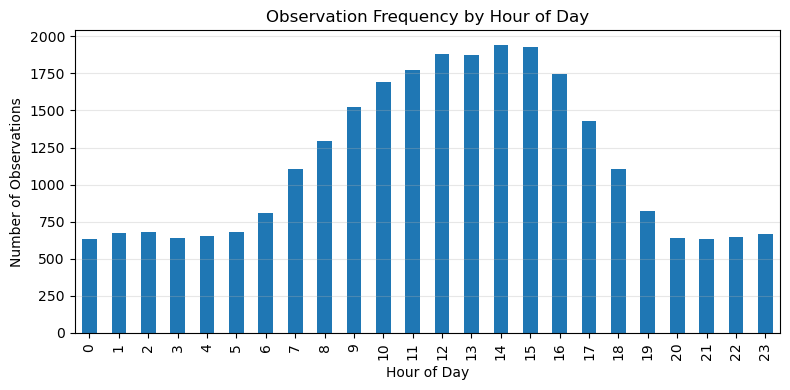

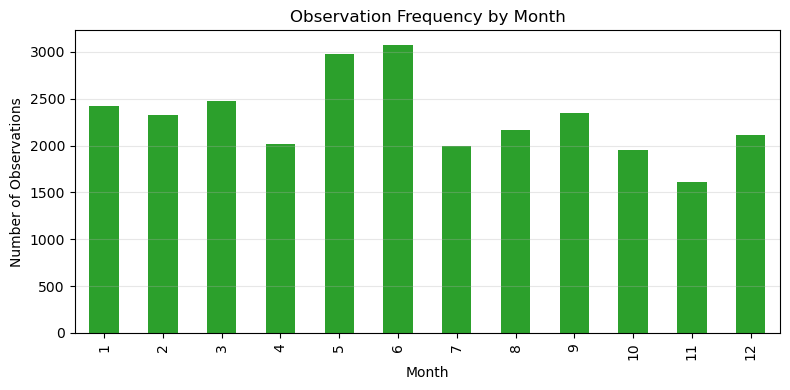

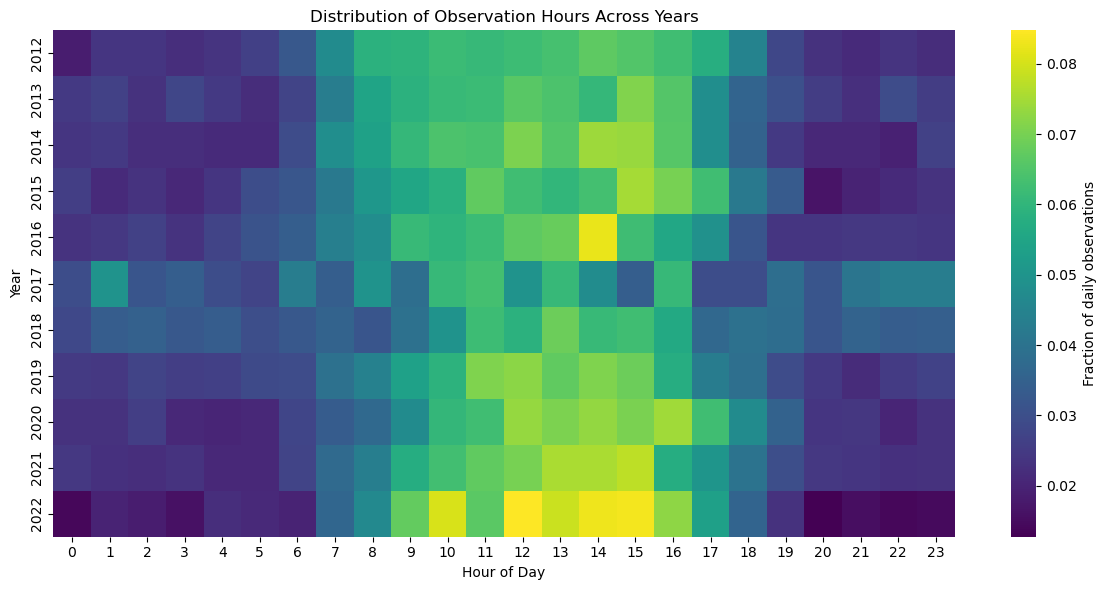

In [6]:
# count observations per hour
hourly_counts = chamau["hour"].value_counts().sort_index()

# plot
plt.figure(figsize=(8,4))
hourly_counts.plot(kind="bar")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Observations")
plt.title("Observation Frequency by Hour of Day")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# count per month
monthly_counts = chamau["month"].value_counts().sort_index()

# plot
plt.figure(figsize=(8,4))
monthly_counts.plot(kind="bar", color="tab:green")
plt.xlabel("Month")
plt.ylabel("Number of Observations")
plt.title("Observation Frequency by Month")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# group by year × hour
hour_year_counts = (
    chamau.groupby(["year", "hour"])
    .size()
    .unstack(fill_value=0)
)

# normalize by total per year (to compare proportions)
hour_year_norm = hour_year_counts.div(hour_year_counts.sum(axis=1), axis=0)

# plot as heatmap
plt.figure(figsize=(12,6))
sns.heatmap(hour_year_norm, cmap="viridis", cbar_kws={"label": "Fraction of daily observations"})
plt.xlabel("Hour of Day")
plt.ylabel("Year")
plt.title("Distribution of Observation Hours Across Years")
plt.tight_layout()
plt.show()



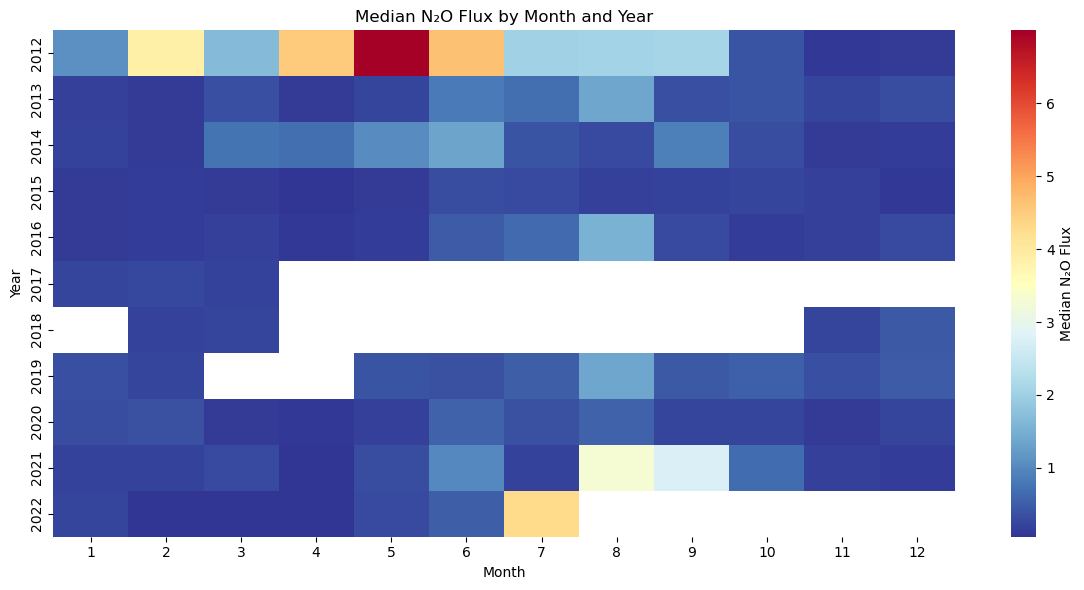

/tmp/ipykernel_2270559/2040960492.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chamau.groupby(["T4_bin", "T15_bin"])["N2O_Flux"]


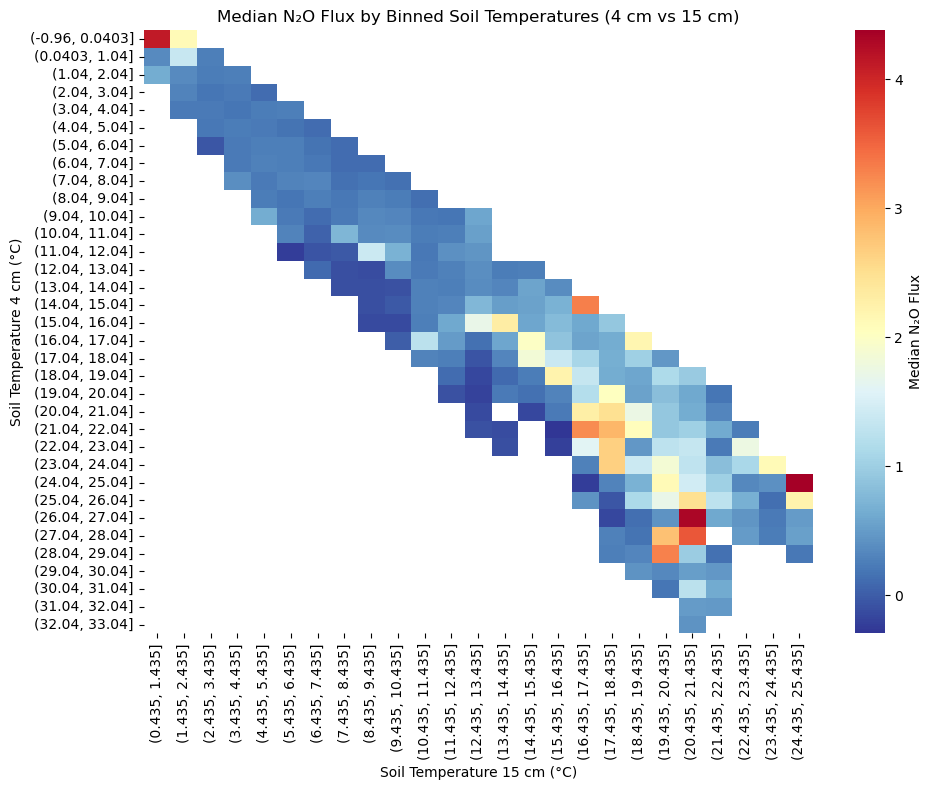

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# compute median N₂O flux per year × hour
median_flux = (
    chamau.groupby(["year", "month"])["N2O_Flux"]
    .median()
    .unstack(fill_value=np.nan)
)

# plot heatmap
plt.figure(figsize=(12,6))
sns.heatmap(
    median_flux,
    cmap="RdYlBu_r",
    cbar_kws={"label": "Median N₂O Flux"},
)
plt.xlabel("Month")
plt.ylabel("Year")
plt.title("Median N₂O Flux by Month and Year")
plt.tight_layout()
plt.show()

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# define bin edges for both temperatures
bins_4cm = np.arange(chamau["SoilTemp_4cm"].min(), chamau["SoilTemp_4cm"].max()+1, 1)
bins_15cm = np.arange(chamau["SoilTemp_15cm"].min(), chamau["SoilTemp_15cm"].max()+1, 1)

# create binned categories
chamau["T4_bin"] = pd.cut(chamau["SoilTemp_4cm"], bins=bins_4cm)
chamau["T15_bin"] = pd.cut(chamau["SoilTemp_15cm"], bins=bins_15cm)

# compute median flux per 2D bin
median_flux_binned = (
    chamau.groupby(["T4_bin", "T15_bin"])["N2O_Flux"]
    .median()
    .unstack(fill_value=np.nan)
)

# plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(
    median_flux_binned,
    cmap="RdYlBu_r",
    cbar_kws={"label": "Median N₂O Flux"},
)
plt.xlabel("Soil Temperature 15 cm (°C)")
plt.ylabel("Soil Temperature 4 cm (°C)")
plt.title("Median N₂O Flux by Binned Soil Temperatures (4 cm vs 15 cm)")
plt.tight_layout()
plt.show()

In [4]:
def plot_time_series(df, vars_to_plot, freq=None):
    """
    Plot time series of selected variables, optionally averaged over a given frequency.
    """
    df = df.copy()
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df = df.set_index("Timestamp")

    # Apply resampling only if frequency is provided
    if freq:
        df = df[vars_to_plot].resample(freq).mean()
        title_suffix = f"(Averaged by {freq})"
    else:
        df = df[vars_to_plot]
        title_suffix = "(Raw data)"

    # --- Plot layout ---
    n_cols = 3
    n_rows = int(len(vars_to_plot) / n_cols) + (len(vars_to_plot) % n_cols > 0)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12), sharex=True)
    axes = axes.flatten()

    # --- Plot each variable ---
    for i, var in enumerate(vars_to_plot):
        ax = axes[i]
        ax.plot(df.index, df[var], lw=1)
        ax.set_title(var, fontsize=10)
        ax.set_ylabel(var)
        ax.grid(True, alpha=0.3)

    # --- Remove empty subplots ---
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"Time Series {title_suffix}", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


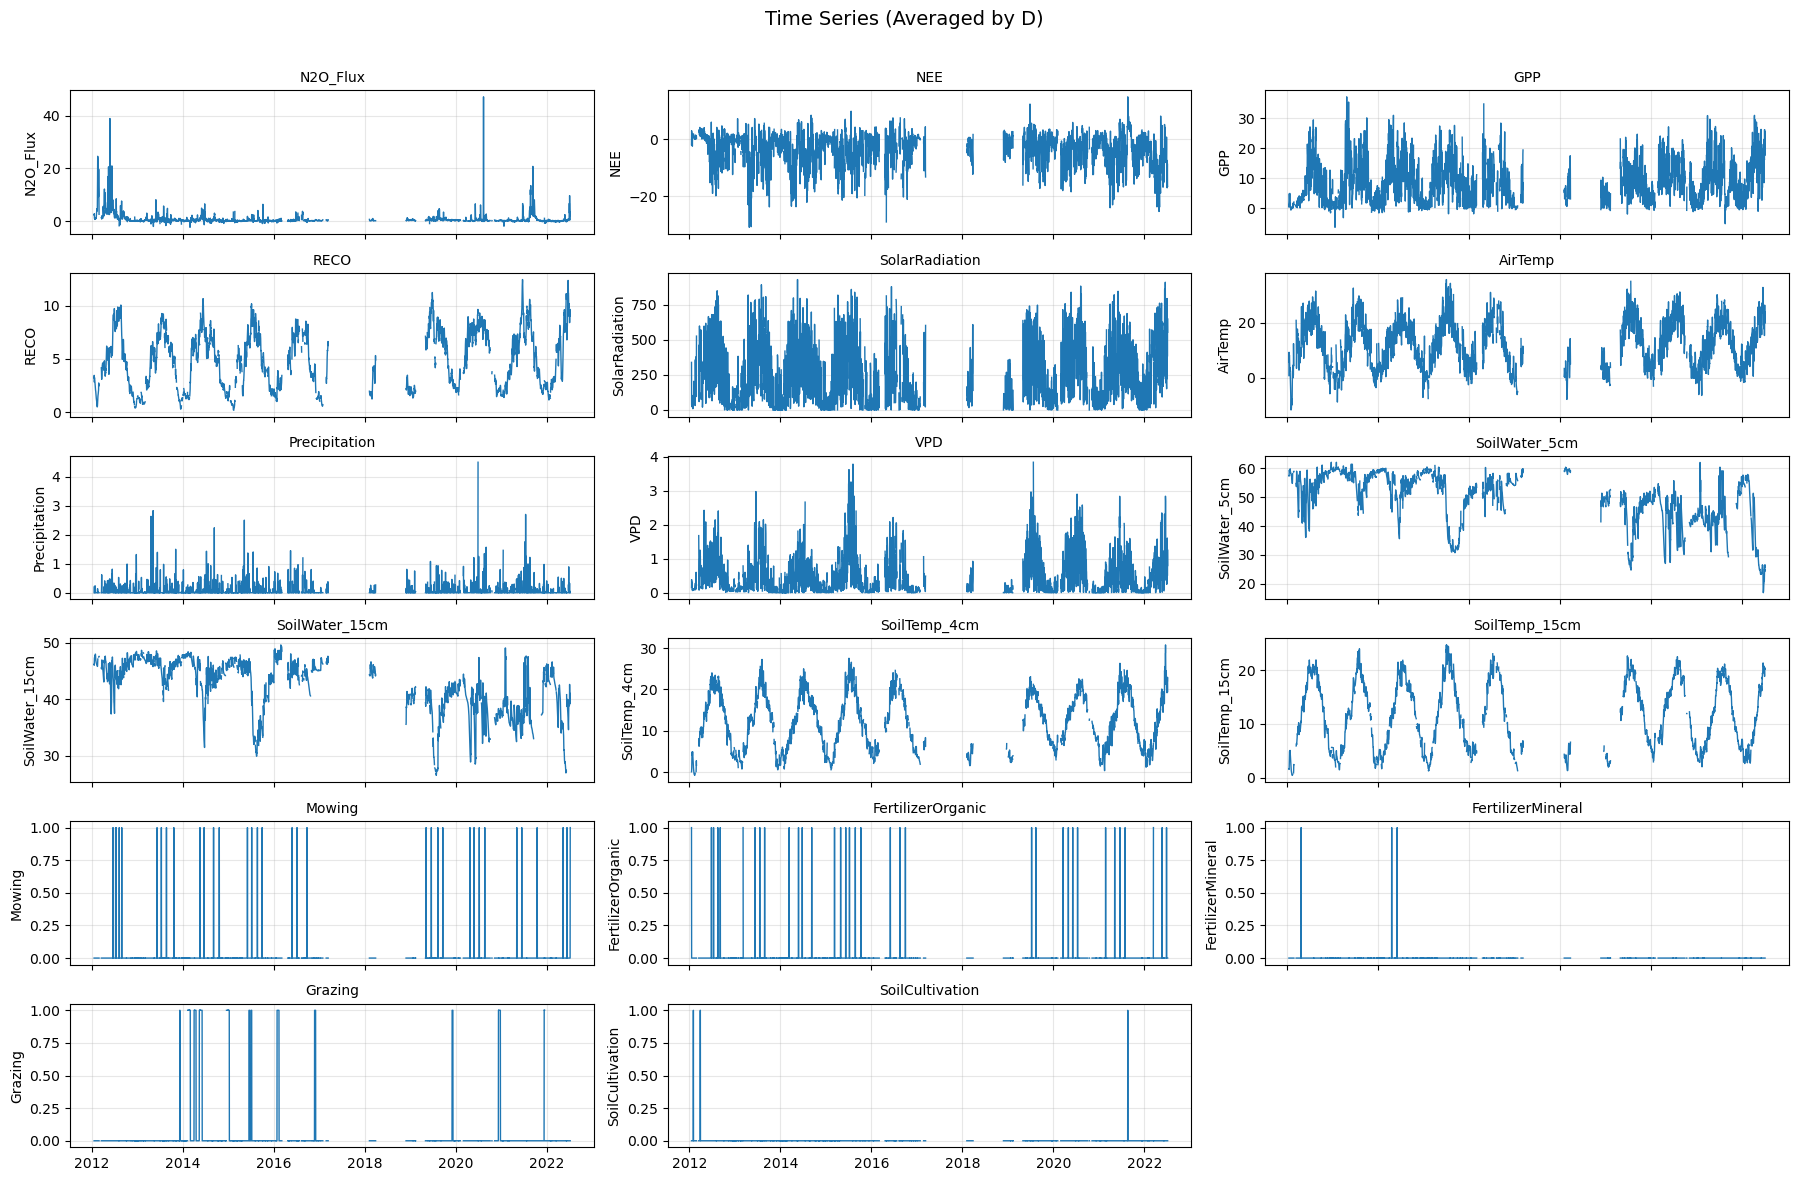

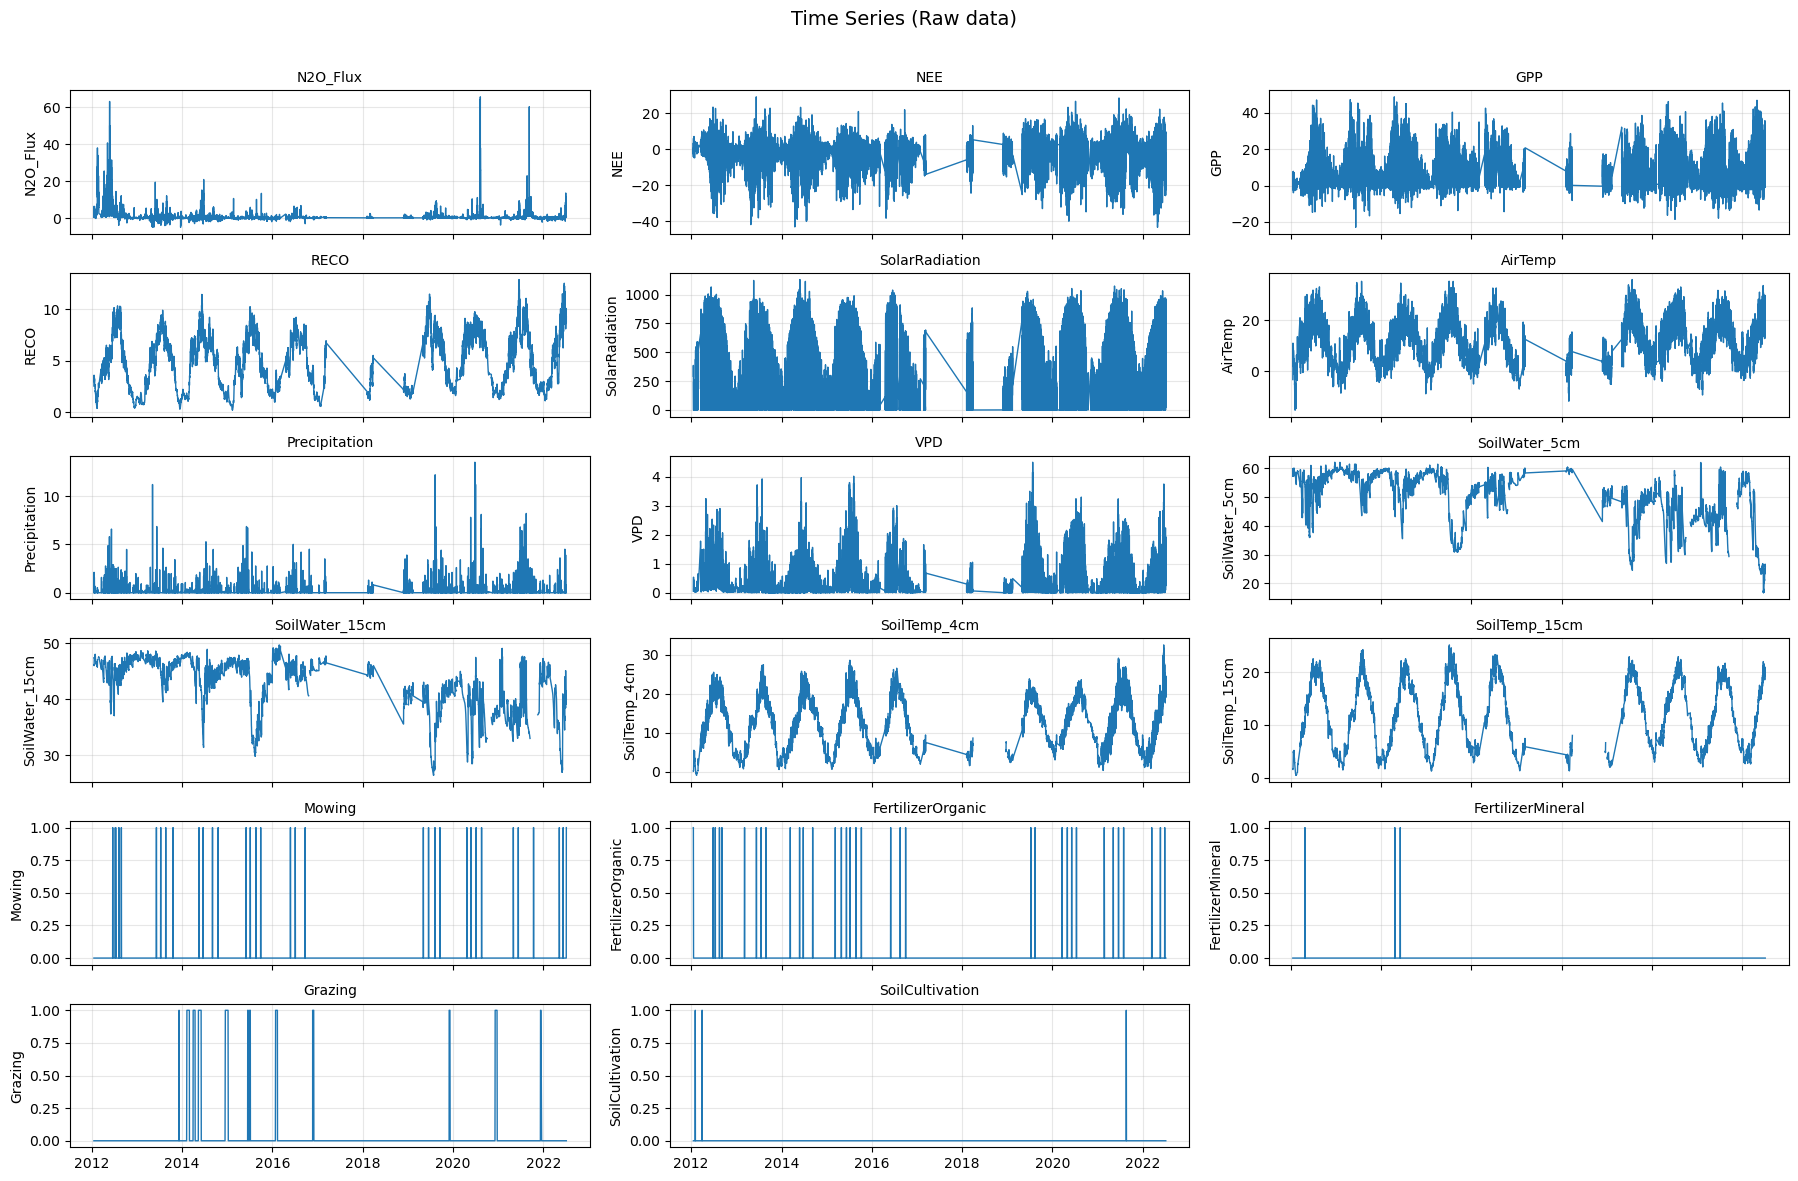

In [5]:
vars_to_plot = [
    "N2O_Flux", "NEE", "GPP", "RECO",
    "SolarRadiation", "AirTemp", "Precipitation",
    "VPD", "SoilWater_5cm", "SoilWater_15cm",
    "SoilTemp_4cm", "SoilTemp_15cm",
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation"
]

# Daily averages
plot_time_series(chamau, vars_to_plot, freq="D")

plot_time_series(chamau, vars_to_plot, freq=None)

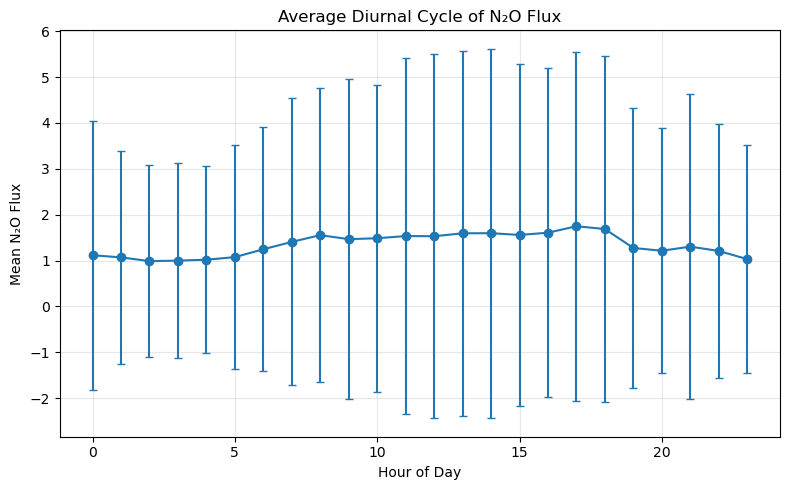

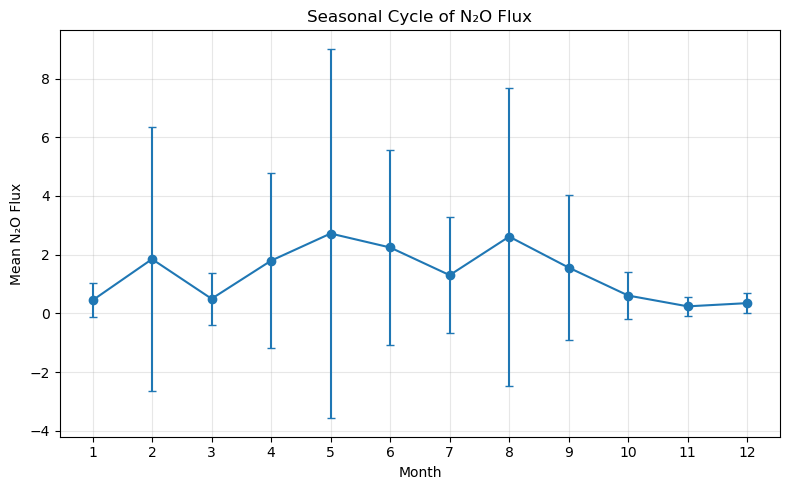

In [13]:
chamau["hour"] = chamau["Timestamp"].dt.hour

hourly_mean = chamau.groupby("hour")["N2O_Flux"].mean()
hourly_std  = chamau.groupby("hour")["N2O_Flux"].std()

plt.figure(figsize=(8, 5))
plt.errorbar(hourly_mean.index, hourly_mean, yerr=hourly_std, fmt="-o", capsize=3)
plt.xlabel("Hour of Day")
plt.ylabel("Mean N₂O Flux")
plt.title("Average Diurnal Cycle of N₂O Flux")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

chamau["month"] = chamau["Timestamp"].dt.month

monthly_mean = chamau.groupby("month")["N2O_Flux"].mean()
monthly_std  = chamau.groupby("month")["N2O_Flux"].std()

plt.figure(figsize=(8, 5))
plt.errorbar(monthly_mean.index, monthly_mean, yerr=monthly_std, fmt="-o", capsize=3)
plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Mean N₂O Flux")
plt.title("Seasonal Cycle of N₂O Flux")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



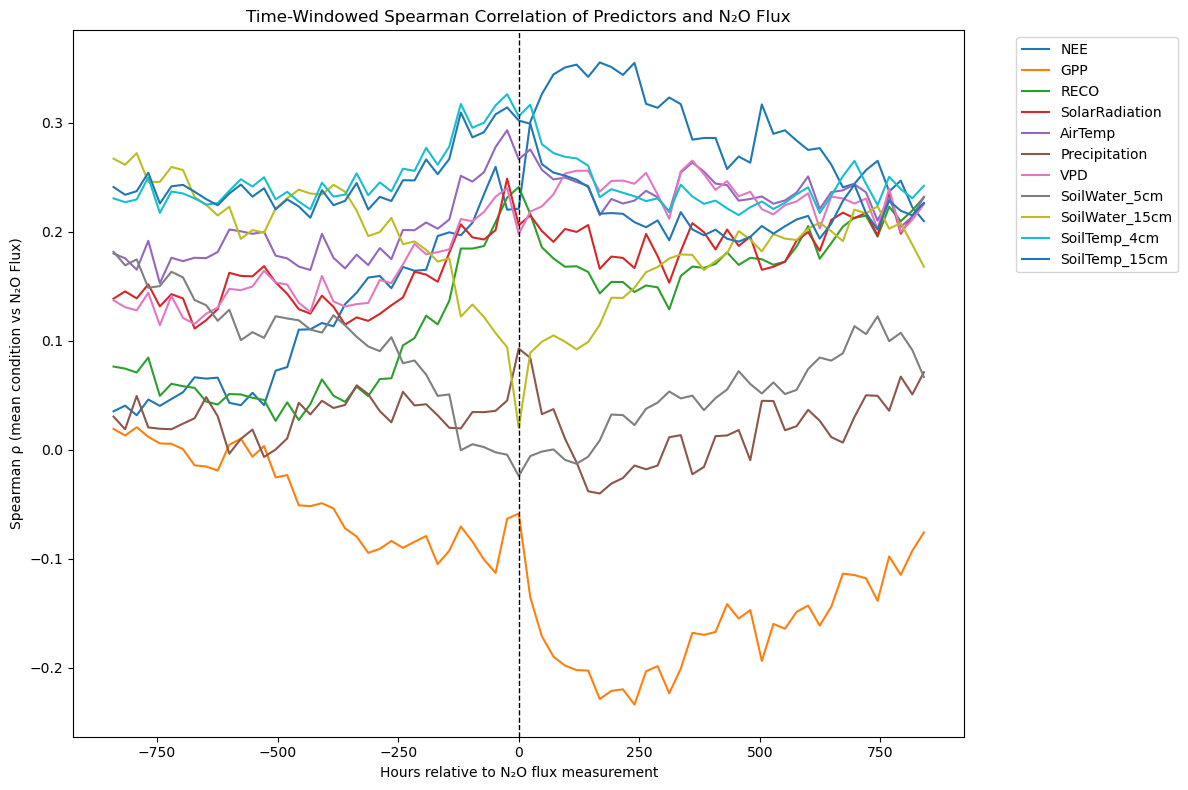

In [19]:
from scipy.stats import spearmanr

# --- Base setup ---
chamau_time_index = chamau.copy()
chamau_time_index = chamau_time_index.set_index("Timestamp")

predictors = [
    "NEE", "GPP", "RECO",
    "SolarRadiation", "AirTemp", "Precipitation", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilTemp_4cm", "SoilTemp_15cm",
]

target = "N2O_Flux"

# --- Parameters ---
window_hours = 24
step_hours   = 24
max_hours    = 5 * 7 * 24  # 5 weeks
offsets      = range(-max_hours, max_hours + step_hours, step_hours)

# --- Rolling mean for predictors ---
window = f"{window_hours}h"
rolling_means = chamau_time_index[predictors].rolling(window=window, closed="left").mean()

# --- Compute lag correlations (Spearman) ---
lag_corrs = {}
for var in predictors:
    corrs = []
    for offset in offsets:
        shifted = rolling_means[var].shift(freq=pd.Timedelta(hours=offset))
        aligned = chamau_time_index[[target]].join(shifted.rename("past_mean")).dropna()
        if len(aligned) > 2:  # need at least 3 points for correlation
            rho, _ = spearmanr(aligned[target], aligned["past_mean"])
            corrs.append(rho)
        else:
            corrs.append(np.nan)
    lag_corrs[var] = (list(offsets), corrs)

# --- Plot results ---
plt.figure(figsize=(12, 8))
for var, (offsets, corrs) in lag_corrs.items():
    plt.plot(offsets, corrs, label=var)

plt.axvline(0, color="k", linestyle="--", lw=1)
plt.xlabel("Hours relative to N₂O flux measurement")
plt.ylabel("Spearman ρ (mean condition vs N₂O Flux)")
plt.title("Time-Windowed Spearman Correlation of Predictors and N₂O Flux")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


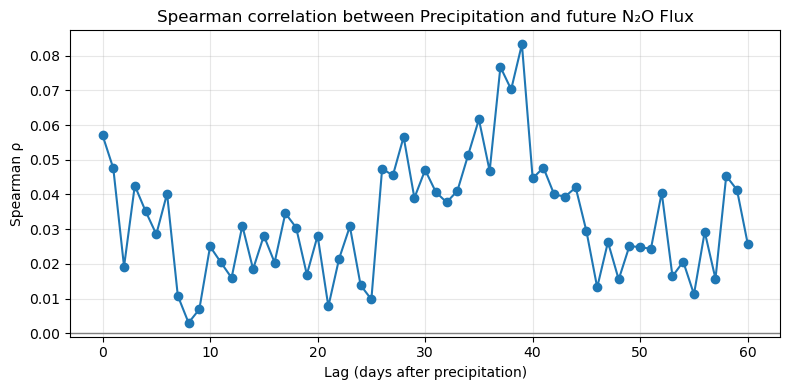

Peak Spearman correlation at lag = 39 days (ρ = 0.083)


In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr

# Filter and resample (keep NaNs for missing days)
chamau_filt = chamau[chamau["N2O_Flux"] >= 0].copy()
chamau_filt = chamau_filt.set_index("Timestamp").resample("D").mean()
chamau_filt = chamau_filt[["Precipitation", "N2O_Flux"]].dropna(subset=["N2O_Flux"])

max_lag = 60
lags = np.arange(0, max_lag + 1)
corrs = []

# --- true calendar-day shift (Spearman) ---
for lag in lags:
    shifted = chamau_filt["Precipitation"].shift(freq=pd.to_timedelta(lag, unit="D"))
    aligned = pd.concat([chamau_filt["N2O_Flux"], shifted], axis=1, join="inner").dropna()

    if aligned.empty:
        corrs.append(np.nan)
    else:
        # Spearman correlation (rank-based, robust to outliers)
        r, _ = spearmanr(aligned["N2O_Flux"], aligned["Precipitation"])
        corrs.append(r)

# --- plot ---
plt.figure(figsize=(8, 4))
plt.plot(lags, corrs, marker="o", color="tab:blue")
plt.axhline(0, color="gray", lw=1)
plt.xlabel("Lag (days after precipitation)")
plt.ylabel("Spearman ρ")
plt.title("Spearman correlation between Precipitation and future N₂O Flux")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

best_lag = lags[np.nanargmax(corrs)]
print(f"Peak Spearman correlation at lag = {best_lag} days (ρ = {np.nanmax(corrs):.3f})")


In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr

def cross_correlation_analysis(df, predictor_vars, target="N2O_Flux", max_lag=60):
    """
    Compute and plot cross-correlations between target and predictors
    using true calendar-day shifts (no filling or interpolation),
    with Spearman rank correlation (robust to outliers).

    Negative lags mean predictor leads (before measurement),
    positive lags mean predictor lags (after measurement).
    """

    # --- prepare data ---
    df = df[df[target] >= 0].copy()
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df = df.set_index("Timestamp").resample("D").mean()   # daily means
    df = df.dropna(subset=[target])                       # keep only valid target days

    # symmetric lag range: before (-max_lag) and after (+max_lag)
    lags = np.arange(-max_lag, max_lag + 1)
    corrs_dict = {}

    # --- compute correlations (Spearman) ---
    for var in predictor_vars:
        corrs = []
        for lag in lags:
            # positive lag → predictor shifted forward (after measurement)
            # negative lag → predictor shifted backward (before measurement)
            shifted = df[var].shift(freq=pd.to_timedelta(lag, unit="D"))
            aligned = pd.concat([df[target], shifted], axis=1, join="inner").dropna()
            if aligned.empty:
                corrs.append(np.nan)
            else:
                rho, _ = spearmanr(aligned[target], aligned[var])
                corrs.append(rho)
        corrs_dict[var] = corrs

    # --- plot all curves ---
    plt.figure(figsize=(10, 6))
    for var, corrs in corrs_dict.items():
        plt.plot(lags, corrs, lw=1.2, label=var)
    plt.axhline(0, color="gray", lw=1)
    plt.axvline(0, color="gray", lw=1, ls="--")
    plt.xlabel("Lag (days)\n← predictor before measurement | predictor after measurement →")
    plt.ylabel("Spearman ρ")
    plt.title("Cross-correlation (before and after measurement)")
    plt.legend(ncol=2, fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- summary table ---
    results = {}
    for var, corrs in corrs_dict.items():
        best_idx = np.nanargmax(np.abs(corrs))
        results[var] = (lags[best_idx], corrs[best_idx])

    results_df = (
        pd.DataFrame(results, index=["Best lag (days)", "Max corr (ρ)"])
        .T
        .sort_values(by="Max corr (ρ)", key=lambda x: x.abs(), ascending=False)
        .round(3)
    )

    return results_df


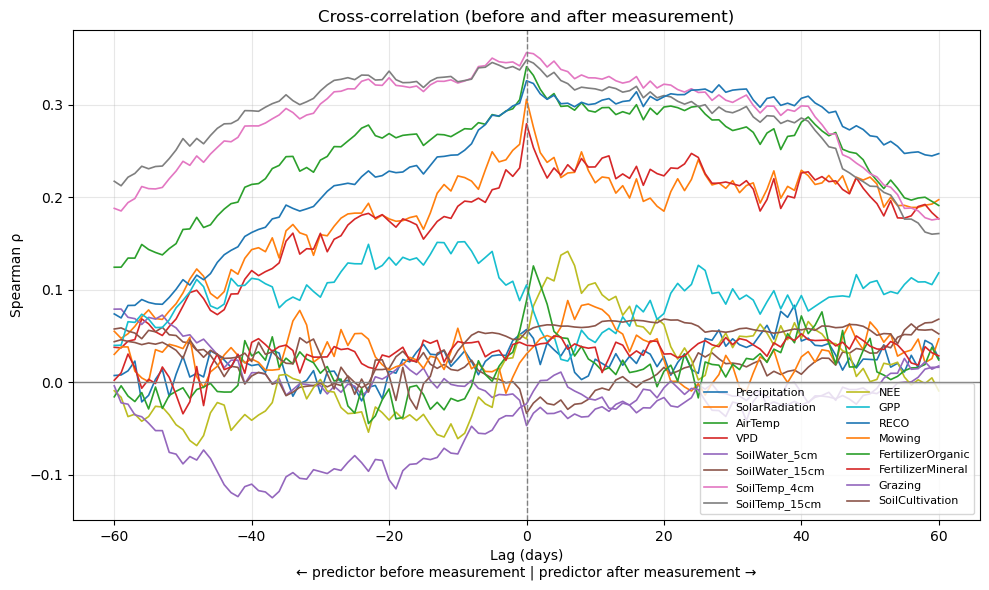

                   Best lag (days)  Max corr (ρ)
SoilTemp_4cm                   0.0         0.356
SoilTemp_15cm                  0.0         0.348
AirTemp                        0.0         0.341
RECO                           0.0         0.326
SolarRadiation                 0.0         0.306
VPD                            0.0         0.279
GPP                           -9.0         0.152
NEE                            6.0         0.141
FertilizerOrganic              1.0         0.126
Grazing                      -37.0        -0.125
Mowing                         6.0         0.088
Precipitation                 39.0         0.083
SoilWater_5cm                -59.0         0.079
SoilCultivation               20.0         0.068
SoilWater_15cm                60.0         0.068
FertilizerMineral             40.0         0.052


In [78]:
predictor_vars = [
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm",
    "SoilTemp_4cm", "SoilTemp_15cm",
    "NEE", "GPP", "RECO",
    "Mowing", "FertilizerOrganic", "FertilizerMineral",
    "Grazing", "SoilCultivation"
]

# Daily
res_daily = cross_correlation_analysis(chamau, predictor_vars, max_lag=60)
print(res_daily)


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

def train_rf_timeseries(df, predictors, target, timestamp_col="Timestamp",
                        test_size=0.3, n_estimators=300, random_state=42, plot=True):
    """
    Train a Random Forest on time-series data using chronological split.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input data containing timestamp, predictors, and target.
    predictors : list of str
        Column names to use as predictors.
    target : str
        Target variable column name.
    timestamp_col : str, optional
        Name of the timestamp column (default: "Timestamp").
    test_size : float, optional
        Fraction of data to reserve for testing (default: 0.3).
    n_estimators : int, optional
        Number of trees in the Random Forest (default: 300).
    random_state : int, optional
        Random seed for reproducibility (default: 42).
    plot : bool, optional
        Whether to display a scatter plot of observed vs predicted values.
    
    Returns
    -------
    results : dict
        Contains model, metrics, feature importances, and predictions.
    """

    # --- ensure time order ---
    df = df.sort_values(timestamp_col).copy()

    # --- extract features/target ---
    X = df[predictors]
    y = df[target]

    # --- handle NaNs ---
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]

    # --- offset for positivity ---
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset

    # --- chronological split ---
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]

    print(f"Train period: {df.iloc[:split_idx][timestamp_col].min()} → {df.iloc[:split_idx][timestamp_col].max()}")
    print(f"Test  period: {df.iloc[split_idx:][timestamp_col].min()} → {df.iloc[split_idx:][timestamp_col].max()}")

    # --- train model ---
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf.fit(X_train, y_train)

    # --- predictions ---
    y_pred = rf.predict(X_test)

    # revert offset
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset

    # --- evaluation ---
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)

    # --- feature importance ---
    importances = pd.Series(rf.feature_importances_, index=predictors).sort_values(ascending=False)

    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")

    # --- plot ---
    if plot:
        plt.figure(figsize=(6, 5))
        plt.scatter(y_test_lin, y_pred_lin, alpha=0.6)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        plt.plot([min_val, max_val], [min_val, max_val], "r--")
        plt.xlabel("Observed N₂O Flux")
        plt.ylabel("Predicted N₂O Flux")
        plt.title(f"Chronological RF (R²={r2:.2f}, ρ={rho:.2f})")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    return {
        "model": rf,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
    }

Train period: 2012-01-18 10:45:00 → 2020-03-03 06:45:00
Test  period: 2020-03-03 07:15:00 → 2022-07-06 09:15:00

Model evaluation:
  R² (linear scale): -0.008
  Spearman ρ:        0.336


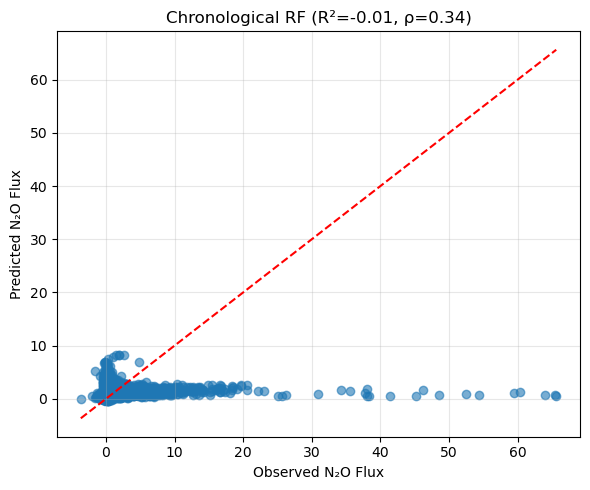

Train period: 2012-01-18 10:45:00 → 2020-04-29 09:15:00
Test  period: 2020-04-29 09:45:00 → 2022-07-06 09:15:00

Model evaluation:
  R² (linear scale): -0.164
  Spearman ρ:        0.312


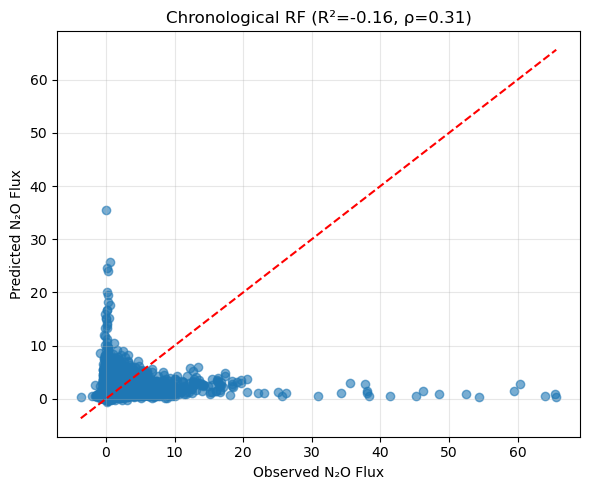

In [23]:
results = train_rf_timeseries(
    df=chamau,
    predictors=[
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm",
        "SoilTemp_4cm", "SoilTemp_15cm",
        "NEE", "GPP", "RECO",
        "Mowing", "FertilizerOrganic", "FertilizerMineral",
        "Grazing", "SoilCultivation"
    ],
    target="N2O_Flux",
)

results = train_rf_timeseries(
    df=chamau,
    predictors=[
    "AirTemp", "VPD",
    "SoilTemp_4cm", "SoilTemp_15cm",
     "RECO", "SolarRadiation"
    ],
    target="N2O_Flux",
)

In [8]:
# Ensure timestamp is datetime and sorted
chamau = chamau.sort_values("Timestamp")

# Compute time difference between consecutive timestamps
chamau["time_diff"] = chamau["Timestamp"].diff()

# Look at large gaps
print(chamau["time_diff"].describe())
chamau[chamau["time_diff"] > "3 days"].head(4)

count                        27460
mean     0 days 03:20:25.324107793
std      2 days 13:25:32.023462203
min                0 days 00:30:00
25%                0 days 00:30:00
50%                0 days 00:30:00
75%                0 days 02:00:00
max              331 days 02:00:00
Name: time_diff, dtype: object


N2O_Flux           Timestamp       NEE       GPP      RECO  \
126316  1.672283 2012-03-16 14:15:00  2.698231  1.462234  4.160465   
140606  0.030938 2013-01-08 07:15:00  0.957182  0.445307  1.402488   
158518  0.080190 2014-01-16 11:15:00 -4.075284  5.755650  1.680366   
176104  0.028624 2015-01-17 20:15:00  0.870610  0.181119  1.051729   

        SolarRadiation    AirTemp  Precipitation       VPD  SoilWater_5cm  \
126316      656.739990  20.622999         0.0000  1.568223      54.713284   
140606        0.000000   2.221600         0.0000  0.078406      58.865906   
158518      106.769997   3.378300         0.0000  0.000000      59.014748   
176104        0.000000   1.200600         0.2634  0.000000      59.782661   

        SoilWater_15cm  SoilTemp_4cm  SoilTemp_15cm  Mowing  \
126316       45.582417        7.1706         5.5416     0.0   
140606       46.960831        5.2890         5.6081     0.0   
158518       47.599476        4.2539         4.5252     0.0   
176104       47.293137        3.6753         4.1535     0.0   

        FertilizerOrganic  FertilizerMineral  Grazing  SoilCultivation  \
126316                0.0                0.0      0.0              0.0   
140606                0.0                0.0      0.0              0.0   
158518                0.0                0.0      0.0              0.0   
176104                0.0                0.0      0.0              0.0   

              time_diff  
126316 18 days 03:30:00  
140606  4 days 17:00:00  
158518  3 days 03:00:00  
176104  4 days 09:30:00

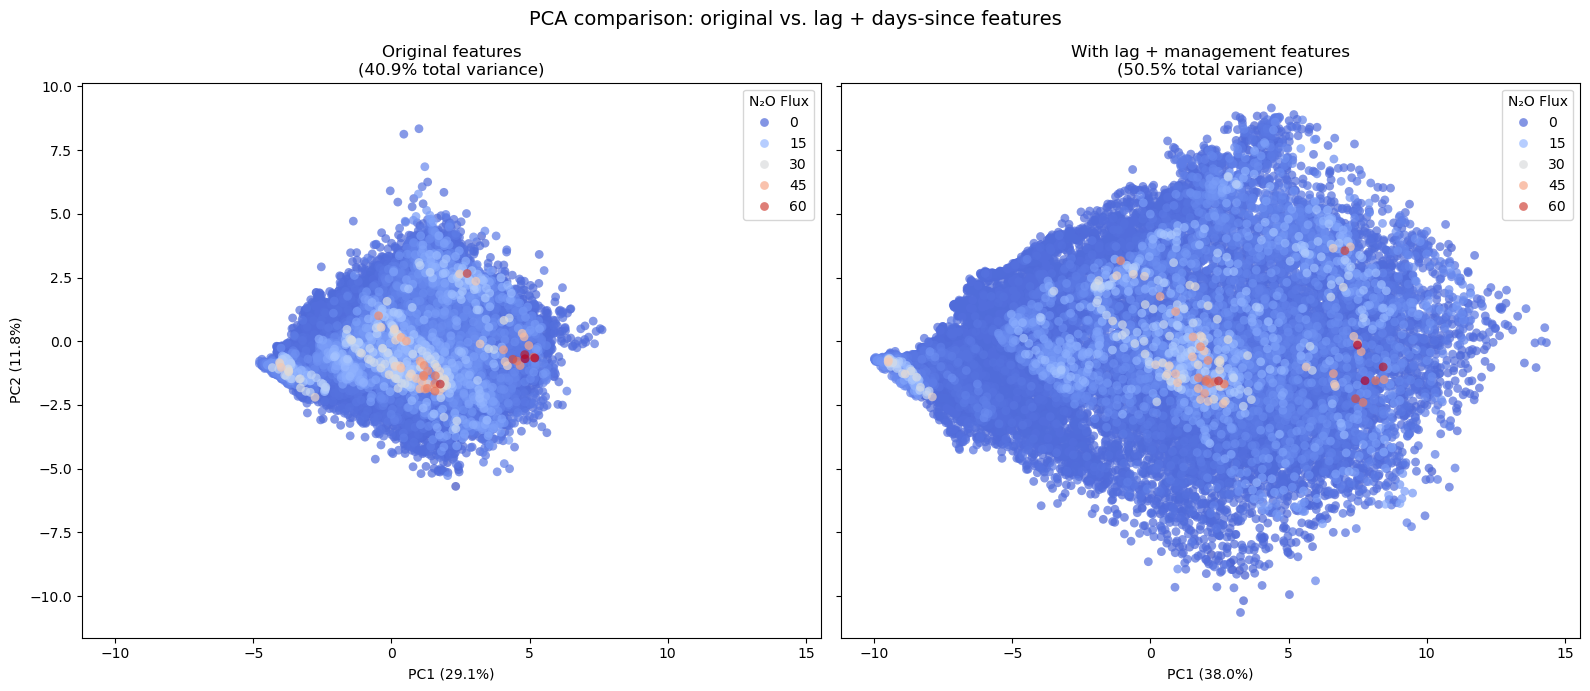

In [14]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------
# --- 1️⃣ PCA on original chamau ---
# ----------------------------------

chamau_clean = chamau.dropna().sort_values(by="N2O_Flux", ascending=True)

X_orig = chamau_clean.drop(columns=["N2O_Flux", "Timestamp"])
y_orig = chamau_clean["N2O_Flux"]

X_orig = X_orig.select_dtypes(include=[np.number])

X_scaled_orig = StandardScaler().fit_transform(X_orig)

pca_orig = PCA(n_components=2)
X_pca_orig = pca_orig.fit_transform(X_scaled_orig)

pca_df_orig = pd.DataFrame(X_pca_orig, columns=["PC1", "PC2"])
pca_df_orig["N2O_Flux"] = y_orig.values

# ---------------------------------
# --- 2️⃣ PCA on chamau_lag ---
# ---------------------------------

chamau_clean_lag = chamau_lag.dropna(subset=["N2O_Flux"]).dropna()
chamau_clean_lag = chamau_clean_lag.sort_values(by="N2O_Flux", ascending=True)

X_lag = chamau_clean_lag.drop(columns=["N2O_Flux", "Timestamp"])
y_lag = chamau_clean_lag["N2O_Flux"]

X_lag = X_lag.select_dtypes(include=[np.number])

X_scaled_lag = StandardScaler().fit_transform(X_lag)

pca_lag = PCA(n_components=2)
X_pca_lag = pca_lag.fit_transform(X_scaled_lag)

pca_df_lag = pd.DataFrame(X_pca_lag, columns=["PC1", "PC2"])
pca_df_lag["N2O_Flux"] = y_lag.values

# ---------------------------------
# --- 3️⃣ Plot side by side ---
# ---------------------------------

fig, axes = plt.subplots(1, 2, figsize=(16,7), sharex=True, sharey=True)

sns.scatterplot(
    data=pca_df_orig,
    x="PC1", y="PC2", hue="N2O_Flux",
    palette="coolwarm", ax=axes[0], s=40, alpha=0.7, edgecolor="none"
)
axes[0].set_title(f"Original features\n({pca_orig.explained_variance_ratio_.sum()*100:.1f}% total variance)")
axes[0].set_xlabel(f"PC1 ({pca_orig.explained_variance_ratio_[0]*100:.1f}%)")
axes[0].set_ylabel(f"PC2 ({pca_orig.explained_variance_ratio_[1]*100:.1f}%)")
axes[0].legend().set_title("N₂O Flux")

sns.scatterplot(
    data=pca_df_lag,
    x="PC1", y="PC2", hue="N2O_Flux",
    palette="coolwarm", ax=axes[1], s=40, alpha=0.7, edgecolor="none"
)
axes[1].set_title(f"With lag + management features\n({pca_lag.explained_variance_ratio_.sum()*100:.1f}% total variance)")
axes[1].set_xlabel(f"PC1 ({pca_lag.explained_variance_ratio_[0]*100:.1f}%)")
axes[1].set_ylabel(f"PC2 ({pca_lag.explained_variance_ratio_[1]*100:.1f}%)")
axes[1].legend().set_title("N₂O Flux")

plt.suptitle("PCA comparison: original vs. lag + days-since features", fontsize=14)
plt.tight_layout()
plt.show()


In [15]:
loadings = pd.DataFrame(
    pca_lag.components_.T,
    index=X.columns,
    columns=["PC1", "PC2"]
)
print(loadings.sort_values("PC1", ascending=False))

                          PC1       PC2
RECO_lag3d           0.179940  0.034153
RECO_lag5d           0.179472  0.038103
SoilTemp_4cm         0.179310  0.049892
RECO_lag1d           0.178936  0.029040
SoilTemp_4cm_lag1d   0.178841  0.053908
...                       ...       ...
SoilWater_5cm_lag7d -0.112145 -0.163423
SoilWater_5cm_lag5d -0.115175 -0.166259
SoilWater_5cm       -0.115642 -0.142447
SoilWater_5cm_lag1d -0.116461 -0.155667
SoilWater_5cm_lag3d -0.116942 -0.163833

[68 rows x 2 columns]


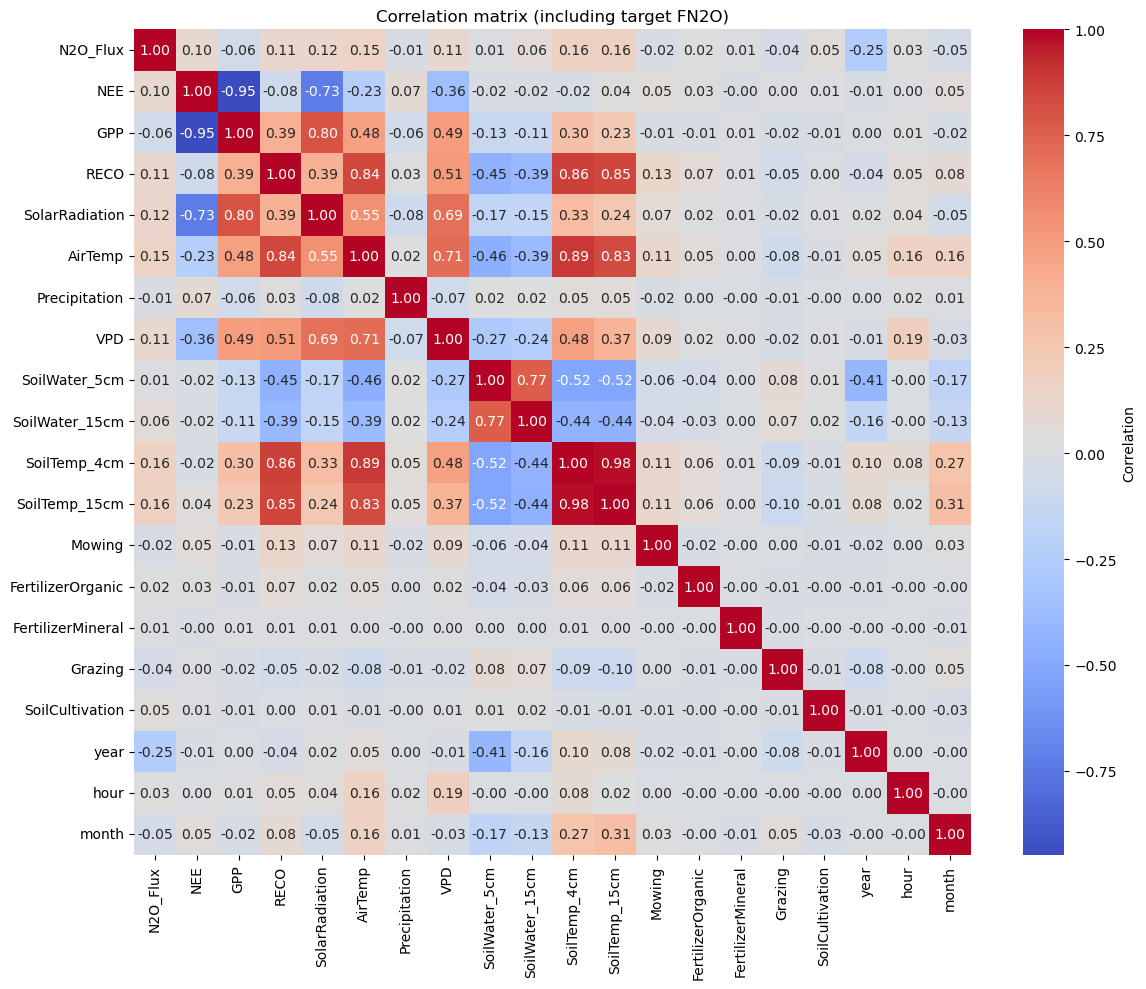

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix (Pearson by default)
corr = chamau.corr(numeric_only=True)

plt.figure(figsize=(12,10))
sns.heatmap(
    corr, 
    annot=True, fmt=".2f", cmap="coolwarm",
    cbar_kws={'label': 'Correlation'}
)
plt.title("Correlation matrix (including target FN2O)")
plt.tight_layout()
plt.show()

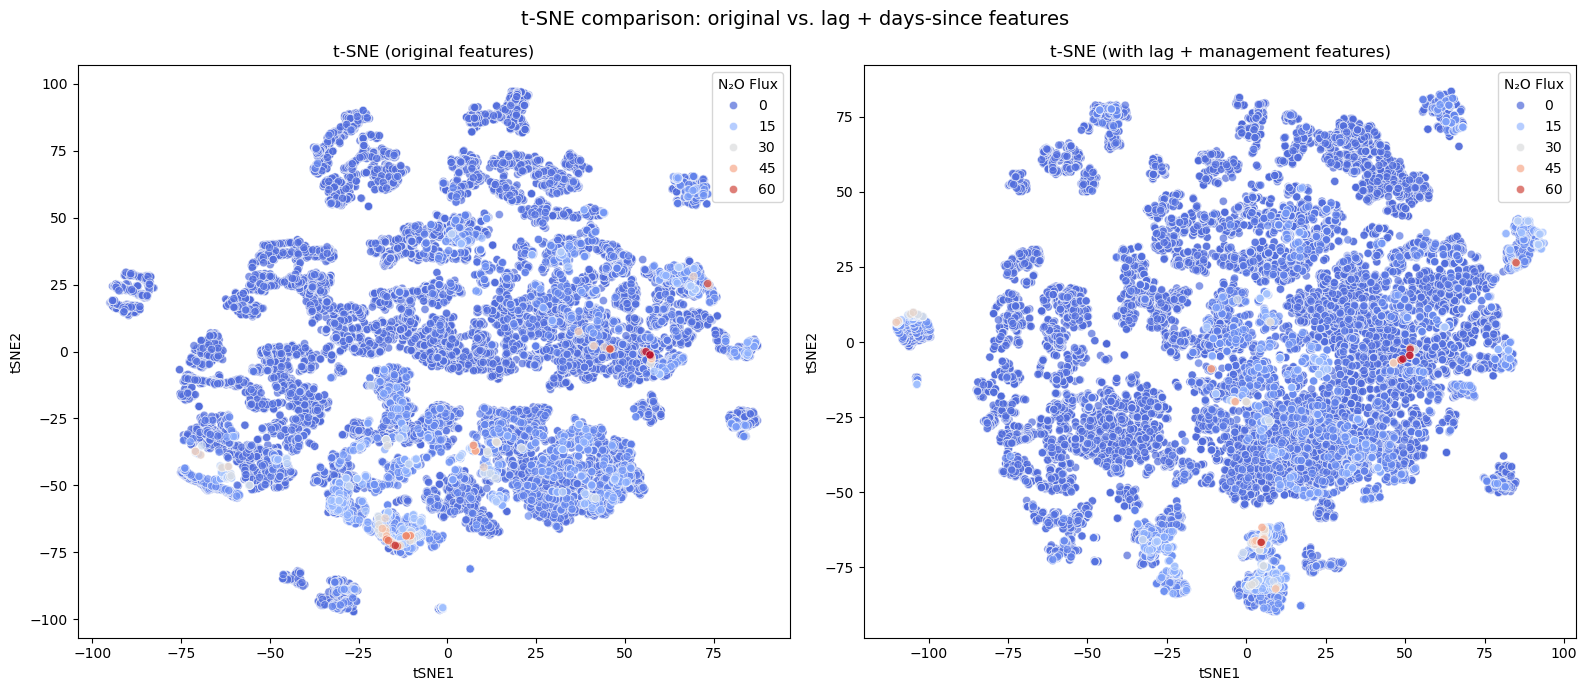

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------
# --- 1️⃣ t-SNE on original chamau ---
# ---------------------------------
chamau_clean = chamau.dropna(subset=["N2O_Flux"]).dropna()
chamau_clean = chamau_clean.sort_values(by="N2O_Flux", ascending=True)

X_orig = chamau_clean.drop(columns=["N2O_Flux", "Timestamp"])
y_orig = chamau_clean["N2O_Flux"]
X_orig = X_orig.select_dtypes(include=[np.number])

X_scaled_orig = StandardScaler().fit_transform(X_orig)

tsne_orig = TSNE(n_components=2, perplexity=90, random_state=42)
X_tsne_orig = tsne_orig.fit_transform(X_scaled_orig)

tsne_df_orig = pd.DataFrame(X_tsne_orig, columns=["tSNE1", "tSNE2"])
tsne_df_orig["N2O_Flux"] = y_orig.values


# ---------------------------------
# --- 2️⃣ t-SNE on chamau_lag ---
# ---------------------------------
chamau_clean_lag = chamau_lag.dropna(subset=["N2O_Flux"]).dropna()
chamau_clean_lag = chamau_clean_lag.sort_values(by="N2O_Flux", ascending=True)

X_lag = chamau_clean_lag.drop(columns=["N2O_Flux", "Timestamp"])
y_lag = chamau_clean_lag["N2O_Flux"]
X_lag = X_lag.select_dtypes(include=[np.number])

X_scaled_lag = StandardScaler().fit_transform(X_lag)

tsne_lag = TSNE(n_components=2, perplexity=90, random_state=42)
X_tsne_lag = tsne_lag.fit_transform(X_scaled_lag)

tsne_df_lag = pd.DataFrame(X_tsne_lag, columns=["tSNE1", "tSNE2"])
tsne_df_lag["N2O_Flux"] = y_lag.values


# ---------------------------------
# --- 3️⃣ Plot side by side ---
# ---------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16,7), sharex=False, sharey=False)

sns.scatterplot(
    data=tsne_df_orig,
    x="tSNE1", y="tSNE2", hue="N2O_Flux",
    palette="coolwarm", s=35, alpha=0.7, ax=axes[0]
)
axes[0].set_title("t-SNE (original features)")
axes[0].legend(title="N₂O Flux")

sns.scatterplot(
    data=tsne_df_lag,
    x="tSNE1", y="tSNE2", hue="N2O_Flux",
    palette="coolwarm", s=35, alpha=0.7, ax=axes[1]
)
axes[1].set_title("t-SNE (with lag + management features)")
axes[1].legend(title="N₂O Flux")

plt.suptitle("t-SNE comparison: original vs. lag + days-since features", fontsize=14)
plt.tight_layout()
plt.show()


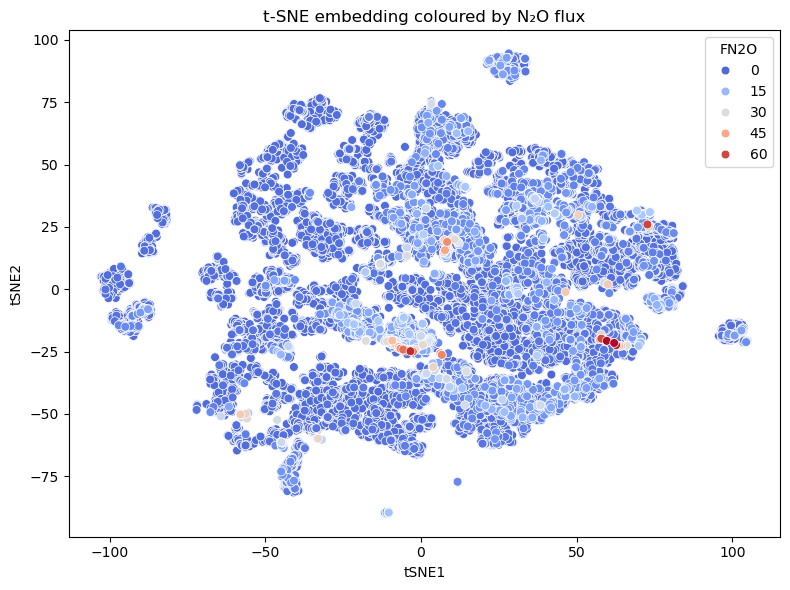

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=90, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame(X_tsne, columns=["tSNE1", "tSNE2"])
tsne_df["FN2O"] = y.values

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=tsne_df, x="tSNE1", y="tSNE2",
    hue="FN2O", palette="coolwarm", s=40
)
plt.title("t-SNE embedding coloured by N₂O flux")
plt.tight_layout()
plt.show()
